In [5]:
import math 
import os 
import numpy as np 
import matplotlib.pyplot as plt
import datetime

import torch
import torch.nn as nn 
import torchvision
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader 
import torchvision.transforms as transforms 
from torchvision import datasets
#from torchvision.models import vgg16
# features, avgpool, classifier 로 이뤄져 있어서 사용 X 



In [6]:
current_time = datetime.datetime.now() + datetime.timedelta(hours= 9)
current_time = current_time.strftime('weight_%Y-%m-%d-%H')

saved_loc = os.path.join('./', current_time)
if os.path.exists(saved_loc):
    shutil.rmtree(saved_loc)
os.mkdir(saved_loc)

print("결과 저장 위치: ", saved_loc)


In [7]:
LABEL_NAME = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
NUM_CLASS = len(LABEL_NAME)
EPOCH = 5 
SAVE_PATH = saved_loc
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [8]:
# vgg16_test = vgg16() 
# vgg16_test._modules.keys()


In [9]:
# vgg16_test._modules # class 1000 - imgenet 전용이라 

In [10]:
class Model(nn.Module):
    def __init__(self, input_channel, label_num, model_name, average = False , input_size = 224, batchnorm = False):
        super(Model,self).__init__()
        

        self.conv1 = make_conv(model_name[1],3)
        # self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.conv2 = make_conv(model_name[2],64)
        # self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = make_conv(model_name[3],128)
        # self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = make_conv(model_name[4],256)
        # self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = make_conv(model_name[5],512)
        # self.Maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc_layer = make_fc(input_size,label_num)

        # self.fc_layer = nn.Sequential(
        #     # CIFAR10은 크기가 32x32이므로 
        #     nn.Linear(512*7*7, 4096),
        #     nn.ReLU(),
        #     nn.Dropout(0.5),
        #     nn.Linear(4096, 4096),
        #     nn.ReLU(True),
        #     nn.Dropout(0.5),
        #     nn.Linear(4096, 1000),
        #     nn.ReLU(True),
        #     nn.Dropout(0.5),
        #     nn.Linear(1000, label_num),
        # )
        
    def forward(self,x):
        x = self.conv1(x)
        # out = self.Maxpool1(x)
        x = self.conv2(x)
        # out = self.Maxpool2(x)
        x = self.conv3(x)
        # out = self.Maxpool3(x)
        x = self.conv4(x)
        # out = self.Maxpool4(x)
        x = self.conv5(x)
        # out = self.Maxpool5(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

vgg11 = {1:[64],2:[128],3:[256,256],4:[512,512],5:[512,512]}
vgg13 = {1:[64,64],2:[128,128],3:[256,256],4:[512,512],5:[512,512]}
vgg16 = {1:[64,64],2:[128,128],3:[256,256,256],4:[512,512,512],5:[512,512,512]}
vgg19 = {1:[64,64],2:[128,128],3:[256,256,256,256],4:[512,512,512,512],5:[512,512,512,512]}

def make_conv(list_conv,input_channels,average = False, batchnorm=False):
    layers = []
    in_planes = input_channels
    for value in list_conv:
        if batchnorm == False: 
            layers.append(nn.Conv2d(in_planes, value, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            in_planes = value
        else : 
            layers.append(nn.Conv2d(in_planes, value, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d())# 논문에는 없지만 개선을 위해 추가 
            layers.append(nn.ReLU())
            in_planes = value

    if average :
        layers.append(nn.AvgPool2d(kernel_size=2, stride = 2)) 
    else : 
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

def make_fc(input_size,label_num):
    layers = []

    if input_size == 224: 
        layers.append(nn.Linear(512*7*7, 4096))
    elif input_size == 32: 
        layers.append(nn.Linear(512*1*1, 4096))
    else :
        pass 
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(0.5))
    layers.append(nn.Linear(4096,4096))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(0.5))
    layers.append(nn.Linear(4096,1000))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(0.5))
    layers.append(nn.Linear(1000, label_num))

    return nn.Sequential(*layers)


In [11]:

vgg16_model = Model(3,NUM_CLASS,vgg16).to(DEVICE)
print(list(vgg16_model.children()))
print('--'*60 )
vgg16_model._modules.keys()


[Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
), Sequential(
  (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
), Sequential(
  (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
), Sequential(
  (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1

odict_keys(['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc_layer'])

In [12]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True,num_workers = 2)

testset = torchvision.datasets.CIFAR10(root='./data', train = False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False,num_workers = 2)



Files already downloaded and verified
Files already downloaded and verified


In [13]:
print("-----Train_datasets----- \n",trainset)
print("-----Test_datasets----- \n",testset)

for X, y in trainloader:
    print('-'*30)
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

-----Train_datasets----- 
 Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
-----Test_datasets----- 
 Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
------------------------------
Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64


truck  frog horse horse   dog   cat  deer  bird horse truck  bird automobile  deer automobile truck horse horse truck  ship   dog horse   dog  ship   cat   dog  deer airplane   dog airplane  bird horse truck  deer   dog truck   cat  deer  frog   dog automobile airplane horse airplane  frog automobile automobile airplane  deer  ship truck   cat  frog  deer horse  ship truck automobile  ship  ship truck   cat  frog airplane horse


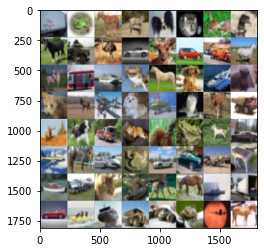

In [14]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % LABEL_NAME[labels[j]] for j in range(64)))


In [15]:
# import torch.optim as optim
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(vgg16_model.parameters(),lr = 0.0001)


In [16]:
loss_arr = [] 
for epoch in range(EPOCH):
    runnig_loss = 0.0 

    # if (epoch>0):
    #     model = VGG16(num_classes = NUM_CLASS).to(DEVICE)
    #     model.load_state_dict(torch.load(save_path))
    #     model.to(DEVICE)

    for i,data in enumerate(trainloader,0):
        input,labels = data 
        input,labels = input.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs= vgg16_model(input)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step() 

        if(loss.item()>1000):
            print(loss.item())
            for param in vgg16_model.parametes():
                print(param.data)
                break

        runnig_loss +=loss.item()
        if i % 50 == 49:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, runnig_loss / 50))
            loss_arr.append(runnig_loss)
            runnig_loss = 0.0 
    
    save_path=SAVE_PATH + "cifar_vgg16.pth"
    torch.save(vgg16_model.state_dict(), save_path)

print('Finished Training')



[1,    50] loss: 2.303
[1,   100] loss: 2.216
[1,   150] loss: 2.073
[1,   200] loss: 1.995
[1,   250] loss: 1.929
[1,   300] loss: 1.854
[1,   350] loss: 1.839
[1,   400] loss: 1.788
[1,   450] loss: 1.764
[1,   500] loss: 1.687
[1,   550] loss: 1.630
[1,   600] loss: 1.625
[1,   650] loss: 1.603
[1,   700] loss: 1.553
[1,   750] loss: 1.539
[2,    50] loss: 1.430
[2,   100] loss: 1.415
[2,   150] loss: 1.377
[2,   200] loss: 1.327
[2,   250] loss: 1.332
[2,   300] loss: 1.298
[2,   350] loss: 1.238
[2,   400] loss: 1.242
[2,   450] loss: 1.262
[2,   500] loss: 1.197
[2,   550] loss: 1.161
[2,   600] loss: 1.181
[2,   650] loss: 1.159
[2,   700] loss: 1.114
[2,   750] loss: 1.058
[3,    50] loss: 0.992
[3,   100] loss: 0.982
[3,   150] loss: 0.924
[3,   200] loss: 0.956
[3,   250] loss: 0.924
[3,   300] loss: 0.918
[3,   350] loss: 0.947
[3,   400] loss: 0.903
[3,   450] loss: 0.878
[3,   500] loss: 0.876
[3,   550] loss: 0.854
[3,   600] loss: 0.773
[3,   650] loss: 0.849
[3,   700] 

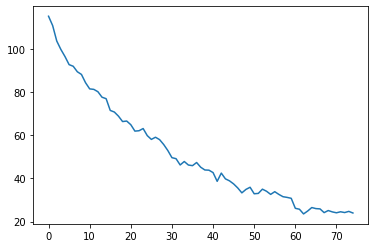

In [17]:
plt.plot(loss_arr)
plt.show()

In [18]:
class_correct = list(0. for i in range(NUM_CLASS))
class_total = list(0. for i in range(NUM_CLASS))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs= vgg16_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(NUM_CLASS):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

accuracy_sum=0
for i in range(10):
    temp = 100 * class_correct[i] / class_total[i]
    print('Accuracy of %5s : %2d %%' % (LABEL_NAME[i], temp))

    accuracy_sum+=temp
print('Accuracy average: ', accuracy_sum/NUM_CLASS)

Accuracy of airplane : 85 %
Accuracy of automobile : 94 %
Accuracy of  bird : 68 %
Accuracy of   cat : 68 %
Accuracy of  deer : 73 %
Accuracy of   dog : 60 %
Accuracy of  frog : 87 %
Accuracy of horse : 82 %
Accuracy of  ship : 87 %
Accuracy of truck : 89 %
Accuracy average:  79.70955507059804


In [20]:
torch.save(vgg16_model,SAVE_PATH + '/vgg16_cifar10_max_5.pt')

In [ ]:
net = torch.load(SAVE_PATH + '/vgg16_cifar10_max_5.pt')
net

Model2GAP(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)